In [1]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
from pathlib import Path
%load_ext autoreload
%autoreload 2


In [19]:
mouse = "mouse2"
df = utils.load_example_data(mouse)

In [5]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)

['COT_test_data', 'visual_and_COT_data']


In [6]:
# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'test']


In [7]:
# download the data for a specific animal
mouse = "ACV001"
local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_session_data(
    project_name=tv_projects[1],
    animal=mouse,
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)

receiving incremental file list

sent 27 bytes  received 77 bytes  208.00 bytes/sec
total size is 1,015,604  speedup is 9,765.42


True

In [8]:
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

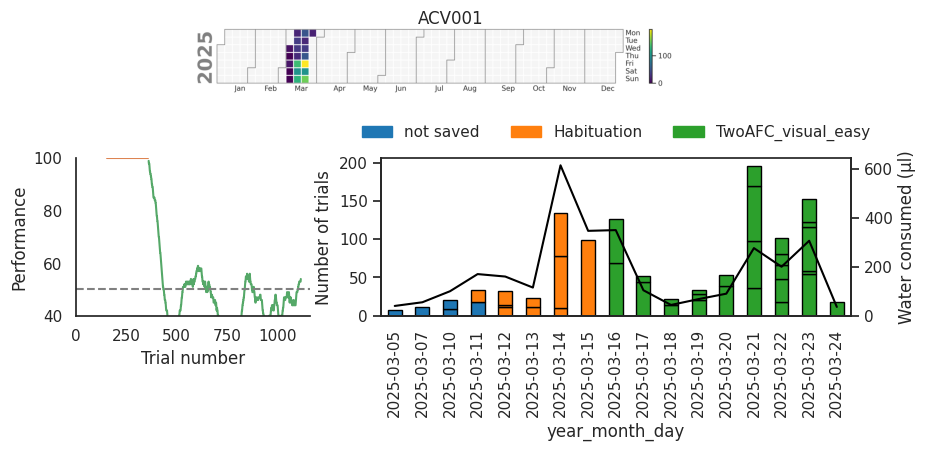

In [12]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
fig = subject_progress_figure(df, mouse, perf_window=100, summary_matrix_plot=False)


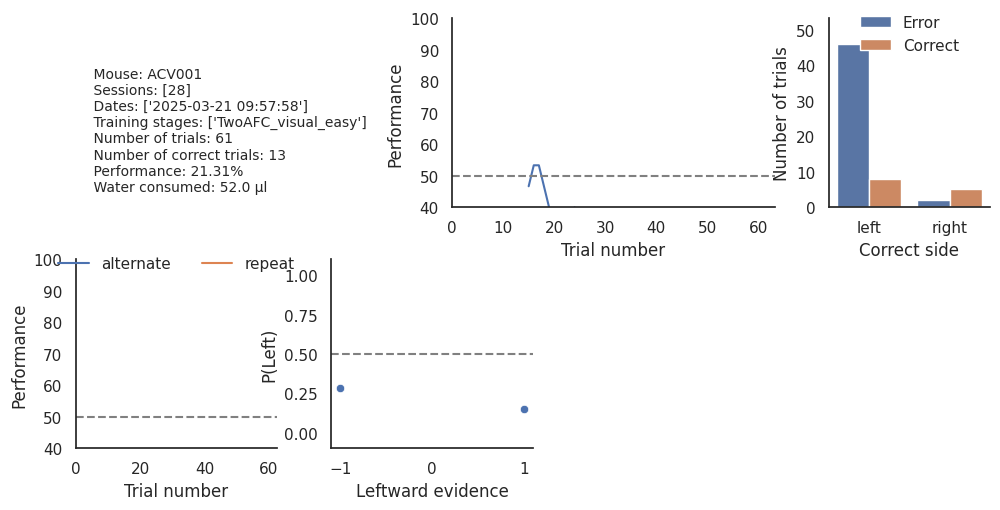

In [16]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
# select the session you want to plot
session = 28
sdf = df[df["session"] == session]
fig = session_summary_figure(sdf, mouse, perf_window=15, width=10, height=5)

In [25]:
from lecilab_behavior_analysis.plots import plot_time_between_trials_and_reaction_time
from lecilab_behavior_analysis.df_transforms import calculate_time_between_trials_and_reaction_time
session = 28
sdf = df[df["session"] == session]
ssdf = calculate_time_between_trials_and_reaction_time(sdf)
ssdf


/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/utils.py:354: RuntimeWarning: All-NaN axis encountered


,session,date,trial,subject,task,system_name,run_mode,Port1In,Port1Out,Port2In,...,correct_side,current_training_stage,difficulty,holding_time,ordered_list_of_events,stimulus_modality,visual_stimulus,water,Time_Between_Trials,Reaction_Time
684,28,2025-03-21 09:57:58,1,ACV001,TwoAFC,village01,Auto,"[1742547488.694504, 1742547488.8047042, 174254...","[1742547488.713504, 1742547501.665704, 1742547...","[1742547508.8814042, 1742547524.716604, 174254...",...,left,TwoAFC_visual_easy,easy,0.154,"['Tup', 'Port1In', 'Port1Out', 'Port1In', 'Por...",visual,"(0.3200608426610537, 0.06401216853221074)",0.0,NaN,11.2027
685,28,2025-03-21 09:57:58,2,ACV001,TwoAFC,village01,Auto,"[1742547614.665345, 1742547614.6867452, 174254...","[1742547614.611445, 1742547614.680845, 1742547...","[1742547618.816945, 1742547621.9755452]",...,left,TwoAFC_visual_easy,easy,0.154,"['Tup', 'Port1Out', 'Port1In', 'Port1Out', 'Po...",visual,"(0.9706356294319286, 0.19412712588638573)",0.0,30.440541,5.4949
686,28,2025-03-21 09:57:58,3,ACV001,TwoAFC,village01,Auto,"[1742547648.5111759, 1742547686.204376, 174254...","[1742547648.473676, 1742547648.5376759, 174254...","[1742547689.946076, 1742547691.4740758, 174254...",...,left,TwoAFC_visual_easy,easy,0.154,"['Tup', 'Port1Out', 'Port1In', 'Port1Out', 'Po...",visual,"(0.3755521262223999, 0.07511042524447999)",4.0,78.677231,0.9172
687,28,2025-03-21 09:57:58,4,ACV001,TwoAFC,village01,Auto,"[1742547724.203294, 1742547724.713794]","[1742547713.206394, 1742547724.688794, 1742547...","[1742547718.161994, 1742547718.9861941, 174254...",...,right,TwoAFC_visual_easy,easy,0.155,"['Tup', 'Port1Out', 'Port2In', 'Port2Out', 'Po...",visual,"(0.7829795743975531, 0.1565959148795106)",4.0,26.500118,NaN
688,28,2025-03-21 09:57:58,5,ACV001,TwoAFC,village01,Auto,[1742547748.4447591],NaN,[1742547747.3376591],...,left,TwoAFC_visual_easy,easy,0.156,"['Tup', 'Port3Out', 'Port2In', 'Tup', 'Port2Ou...",visual,"(0.5952417751657763, 0.11904835503315525)",4.0,20.158965,0.8436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,28,2025-03-21 09:57:58,57,ACV001,TwoAFC,village01,Auto,[1742549191.532059],[1742549185.255759],"[1742549188.454859, 1742549188.468159, 1742549...",...,left,TwoAFC_visual_easy,easy,0.167,"['Tup', 'Port1Out', 'Port2In', 'Port2Out', 'Po...",visual,"(0.7301231329494715, 0.1460246265898943)",0.0,9.999225,2.8206
741,28,2025-03-21 09:57:58,58,ACV001,TwoAFC,village01,Auto,"[1742549201.7528021, 1742549201.803702, 174254...","[1742549194.1438022, 1742549201.777102, 174254...",[1742549196.3671021],...,left,TwoAFC_visual_easy,easy,0.167,"['Tup', 'Port1Out', 'Port2In', 'Tup', 'Port2Ou...",visual,"(0.10430738199521679, 0.020861476399043358)",0.0,7.837843,5.2035
742,28,2025-03-21 09:57:58,59,ACV001,TwoAFC,village01,Auto,[1742549214.749625],"[1742549204.7713249, 1742549215.744825]","[1742549207.951825, 1742549213.8180249]",...,left,TwoAFC_visual_easy,easy,0.167,"['Tup', 'Port1Out', 'Port2In', 'Tup', 'Port2Ou...",visual,"(0.9380965794202032, 0.18761931588404063)",0.0,17.323023,0.8773
743,28,2025-03-21 09:57:58,60,ACV001,TwoAFC,village01,Auto,"[1742549215.76945, 1742549225.67055]",[1742549219.79175],[1742549222.02265],...,left,TwoAFC_visual_easy,easy,0.167,"['Tup', 'Port1In', 'Port1Out', 'Port2In', 'Tup...",visual,"(0.5908522719549152, 0.11817045439098305)",0.0,8.345525,3.4527


<Axes: ylabel='Frequency'>

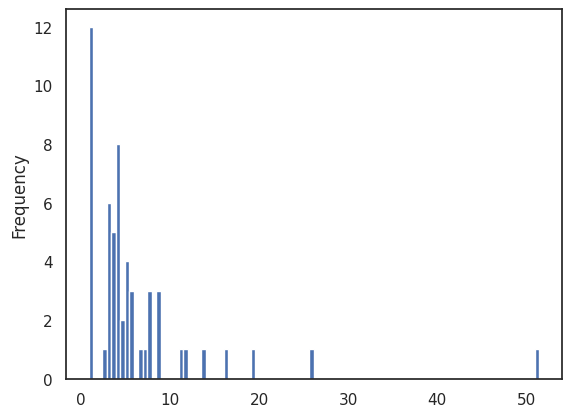

In [29]:
ssdf.Reaction_Time.plot(kind="hist", bins=100)